# In this notebook - we will use the APIs from Apple Music, LastFM, and Spotify to collect the top 5 tracks per region

Leveraging Client and Secret keys, we will authenticate with each of the above platforms and collect data about the top tracks per region.  After collecting the data, the goal is to get information about the tracks, and identify any trends that are presented in the data

# After collecting data from each platform, we will clean and aggregate additional information about the tracks

Each API offers different insights into the data. After collecting the top 5 by region, Apple's API give us a clear genre of each song type.  In an effort to standardize/normalize the data, we will use Apple's API to collect information about the genre

Once that is complete, Spotify's API give us detailed information about the audio features of the track.  We will be reviewing the following data points:

**Danceability** describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least # danceable and 1.0 is most danceable. 
    
**Energy** is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

**Pitch Class** = Tonal counterparts:
    0=C
    1=C♯
    2=D
    3=D♯
    4=E
    5=F
    6=F♯
    7=G
    8=G♯
    9=A
    10=t or Aor A♯
    11=e or B

**Loudness** - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. 

**Speechiness** detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 

**Accousticness** - a confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. 

**Instrumentalness** - Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. 

**Liveness** - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. 

**Valence** - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [1]:
#importing the neccessary libraries we will need to run our data and analysis

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys
import csv
import seaborn as sns

from googletrans import Translator 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import json
from pprint import pprint 

import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2

from config import lastfm_api_key, CLIENT_ID, CLIENT_SECRET

# Using a quick Google Search we found the top countries as it pertains to music.  We then selected the countries that data was readily available for across all of our platforms 

Countries include:
<ul>
    <li>Hong Kong</li>
    <li>Netherlands</li>
    <li>Australia</li>
    <li>Canada</li>
    <li>France</li>
    <li>Japan</li>
    <li>United Kingdom</li>
    <li>Germany</li>
    <li>United States</li>
</ul>

In [2]:
#list of countries we narrow down to sort through our data

countries = ['hk', 'nl', 'au', 'ca', 'fr', 'jp', 'gb', 'de', 'us' ]

# Apple Music API to get the top songs in the above countries

In [3]:
#create a dataframe that takes in all the top 5 songs from each country on our list

song_list = []
artist_list = []
album_list = []
country_list = []
genre_list = []
rank = []

for country in countries:
    top_list = []
    music_url = f"https://rss.itunes.apple.com/api/v1/{country}/apple-music/top-songs/all/5/explicit.json"
    
    try:
        response = requests.get(music_url).json()
        top_list.append(response["feed"]["results"])
        country_df = pd.DataFrame(top_list)
        for x in range (0,5):
            rank.append(x+1)
            song_list.append(country_df[x][0]['name'])
            country_list.append(country)
            artist_list.append(country_df[x][0]['artistName'])
            album_list.append(country_df[x][0]["collectionName"])
            genre_list.append(country_df[x][0]["genres"][0]["name"])
        
    except:
        print(f"Can't find {country}. Skipping... ")

# Create a dataframe with the country, song name and details, and the source        
apple_top_df = pd.DataFrame({
    "Country" : country_list,
    "Name" : song_list,
    "Artist" : artist_list,
    "Album" : album_list,
    "Genre" : genre_list,
    "Rank" : rank
})

#Clean the dataframe to match our pre-decided naming convention for the group
apple_top_df['Country'] = apple_top_df['Country'].replace({'hk': 'Hong Kong',
                           'nl': 'Netherlands',
                           'au': 'Australia',
                           'ca': 'Canada',
                           'fr': 'France',
                           'jp': 'Japan',
                           'gb': 'UK',
                           'de': 'Germany',
                           'us': 'US'
                          })
apple_top_df['Source'] = 'Apple'
apple_top_df.head()

,Country,Name,Artist,Album,Genre,Rank,Source
0,Hong Kong,Señorita,Shawn Mendes & Camila Cabello,Señorita - Single,流行樂,1,Apple
1,Hong Kong,Into the Unknown,Idina Menzel & AURORA,Frozen 2 (Original Motion Picture Soundtrack /...,原聲帶,2,Apple
2,Hong Kong,說好不哭,周杰倫 & 阿信,說好不哭 - Single,國語流行樂,3,Apple
3,Hong Kong,Show Yourself,Idina Menzel & Evan Rachel Wood,Frozen 2 (Original Motion Picture Soundtrack /...,原聲帶,4,Apple
4,Hong Kong,讓愛高飛 (劇集《多功能老婆》片尾曲),周柏豪,讓愛高飛 (劇集《多功能老婆》片尾曲) - Single,廣東歌,5,Apple


In [4]:
#cleaning the dataframe to be more readable 

translator = Translator()

apple_top_df['Genre'] = apple_top_df['Genre'].apply(translator.translate, dest='en').apply(getattr, args=('text',))
apple_top_df['Genre'] = apple_top_df['Genre'].replace({'pop music' : 'Pop', 
                                                                   'Mandarin pop music' : 'Pop',
                                                                   'Alternative Music' : 'Alternative',
                                                                   'R & B, soul' : 'R&B/Soul',
                                                                   'priest' : 'Priest'
                                                                })
apple_top_df.head()

,Country,Name,Artist,Album,Genre,Rank,Source
0,Hong Kong,Señorita,Shawn Mendes & Camila Cabello,Señorita - Single,Pop,1,Apple
1,Hong Kong,Into the Unknown,Idina Menzel & AURORA,Frozen 2 (Original Motion Picture Soundtrack /...,Soundtrack,2,Apple
2,Hong Kong,說好不哭,周杰倫 & 阿信,說好不哭 - Single,Pop,3,Apple
3,Hong Kong,Show Yourself,Idina Menzel & Evan Rachel Wood,Frozen 2 (Original Motion Picture Soundtrack /...,Soundtrack,4,Apple
4,Hong Kong,讓愛高飛 (劇集《多功能老婆》片尾曲),周柏豪,讓愛高飛 (劇集《多功能老婆》片尾曲) - Single,Guangdong song,5,Apple


# LastFM API to get the top tracks by region in radio

In [5]:
#start of lastFM data search

jsonFormat = '&format=json'

lastfm_url = 'http://ws.audioscrobbler.com/2.0/?method=chart.gettoptracks'
lastfm_url_end = '&api_key=' + lastfm_api_key + jsonFormat

In [6]:
# Get the top 5 tracks
limit = '5'

countries = ["Hong Kong", "Netherlands", "Australia", 
             "Canada", "France", "Japan", "united kingdom", "Germany", "united states"]
song_list = []
artist_list = []
country_list = []
rank = []

for country in countries:
    top_list = []
    urlgeo = lastfm_url+'&limit=' + limit + '&country=' + country + lastfm_url_end
    try:
        lastfm_response = requests.get(urlgeo).json()
        top_list.append(lastfm_response["tracks"]["track"])
        temp_df = pd.DataFrame(top_list)
        for x in range (0,5):
            rank.append(x+1)
            song_list.append(temp_df[x][0]['name'])
            country_list.append(country)
            artist_list.append(temp_df[x][0]['artist']['name'])
    except:
        print(f"Couldn't find {country}")

In [7]:
#Build the dataframe for LastFM Data
lastfm_top_df=pd.DataFrame({
    "Country" : country_list,
    "Artist" : artist_list,
    "Name" : song_list,
    "Rank" : rank
})

lastfm_top_df["Source"] = "LastFM"

lastfm_top_df.head()

,Country,Artist,Name,Rank,Source
0,Hong Kong,Billie Eilish,Everything I Wanted,1,LastFM
1,Hong Kong,Billie Eilish,bad guy,2,LastFM
2,Hong Kong,The Weeknd,Heartless,3,LastFM
3,Hong Kong,Dua Lipa,doN'T StArT nOw,4,LastFM
4,Hong Kong,Mariah Carey,All I Want for Christmas Is You,5,LastFM


In [8]:
# Get the album information for each track
# Need to use another API call to get Album information
albums = []
for index, row in lastfm_top_df.iterrows():
    try:
        track_url = 'http://ws.audioscrobbler.com/2.0/?method=track.getInfo&artist=' + row['Artist'] + '&track=' + row['Name'] + '&autocorrect=1' + lastfm_url_end
        lastfm_response = requests.get(track_url).json()
        albums.append(lastfm_response['track']['album']['title'])
    except:
        print(f"Couldn\'t find track information for {row['Name']}")
        albums.append(row['Name'])

Couldn't find track information for doN'T StArT nOw
Couldn't find track information for doN'T StArT nOw
Couldn't find track information for doN'T StArT nOw
Couldn't find track information for doN'T StArT nOw
Couldn't find track information for doN'T StArT nOw
Couldn't find track information for doN'T StArT nOw
Couldn't find track information for doN'T StArT nOw
Couldn't find track information for doN'T StArT nOw
Couldn't find track information for doN'T StArT nOw


In [9]:
lastfm_top_df["Album"] = albums
lastfm_top_df.replace(to_replace="united kingdom", value="UK", inplace=True)
lastfm_top_df.replace(to_replace="united states", value="US", inplace=True)

# Switching to Apple Music's API to get Genre information for LastFM Tracks

As mentioned earlier, Apple Music cleanly generates Genre information as compared to the other APIs.  We decided to standardize on Apple for continuity

In [10]:
genre_list = []

for song in lastfm_top_df["Name"]:
    artist = f"term={song}"
    media = 'media=music'
    entity = 'entity=song'
    limit = 'limit=1'

    url = 'http://itunes.apple.com/search?' + artist + "&" + media + "&" + entity + "&" + limit
    response = requests.get(url).json()

    genre_list.append(response["results"][-1]['primaryGenreName'])

lastfm_top_df["Genre"] = genre_list
lastfm_top_df = lastfm_top_df[['Country', 'Name', 'Artist', 'Album', 'Genre', 'Rank', 'Source']]

lastfm_top_df.head()

,Country,Name,Artist,Album,Genre,Rank,Source
0,Hong Kong,Everything I Wanted,Billie Eilish,everything i wanted,Alternative,1,LastFM
1,Hong Kong,bad guy,Billie Eilish,"Now That's What I Call Music, Vol. 71",Alternative,2,LastFM
2,Hong Kong,Heartless,The Weeknd,Heartless,Country,3,LastFM
3,Hong Kong,doN'T StArT nOw,Dua Lipa,doN'T StArT nOw,Pop,4,LastFM
4,Hong Kong,All I Want for Christmas Is You,Mariah Carey,Merry Christmas,Holiday,5,LastFM


# Spotify API to obtain top tracks by geo

In [11]:
#start of spotify data search

spotify = spotipy.Spotify()
credentials = oauth2.SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET)

token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)

In [12]:
spotify =spotipy.Spotify(auth=token)
playlist_name = []
p_id = []
owners_p=[]

playlists=spotify.search(q="Top 50",type = "playlist",limit=50)
for x,y in enumerate(playlists["playlists"]["items"]):
    play_name = (x,y["name"])
    playlist_id = y["uri"]
    owners = (y["owner"]["display_name"])
    #owner_final=owners[]
    if owners == "spotifycharts":
        playlist_name.append(play_name[1])
        p_id.append(playlist_id)
        owners_p.append(owners)

play_final = {
    "Playlist Name":playlist_name,
    "Playlist_ID":p_id,
    "Owners":owners_p
}
playlist_df = pd.DataFrame(play_final)
playlist_df.head()

,Playlist Name,Playlist_ID,Owners
0,Global Top 50,spotify:playlist:37i9dQZEVXbMDoHDwVN2tF,spotifycharts
1,Brazil Top 50,spotify:playlist:37i9dQZEVXbMXbN3EUUhlg,spotifycharts
2,Spain Top 50,spotify:playlist:37i9dQZEVXbNFJfN1Vw8d9,spotifycharts
3,Germany Top 50,spotify:playlist:37i9dQZEVXbJiZcmkrIHGU,spotifycharts
4,Mexico Top 50,spotify:playlist:37i9dQZEVXbO3qyFxbkOE1,spotifycharts


## We noticed that Hong Kong didn't show up in this list even though it follows the same naming convention.  So we added in code to pick up the appropriate playlist

In [13]:
playlist_name_t = []
p_id_t = []
owners_p_t=[]

playlists=spotify.search(q="Hong Kong Top 50",type = "playlist",limit=50)
for x,y in enumerate(playlists["playlists"]["items"]):
    play_name = (x,y["name"])
    playlist_id = y["uri"]
    owners = (y["owner"]["display_name"])
    #owner_final=owners[]
    if owners == "spotifycharts":
        playlist_name_t.append(play_name[1])
        p_id_t.append(playlist_id)
        owners_p_t.append(owners)

play_final_t = {
    "Playlist Name":playlist_name_t,
    "Playlist_ID":p_id_t,
    "Owners":owners_p_t
}
playlist_df_t = pd.DataFrame(play_final_t)


In [14]:
final_playists_df = pd.concat([playlist_df,playlist_df_t])
final_playists_df.reset_index(inplace=True, drop=True)
final_playists_df

,Playlist Name,Playlist_ID,Owners
0,Global Top 50,spotify:playlist:37i9dQZEVXbMDoHDwVN2tF,spotifycharts
1,Brazil Top 50,spotify:playlist:37i9dQZEVXbMXbN3EUUhlg,spotifycharts
2,Spain Top 50,spotify:playlist:37i9dQZEVXbNFJfN1Vw8d9,spotifycharts
3,Germany Top 50,spotify:playlist:37i9dQZEVXbJiZcmkrIHGU,spotifycharts
4,Mexico Top 50,spotify:playlist:37i9dQZEVXbO3qyFxbkOE1,spotifycharts
5,Netherlands Top 50,spotify:playlist:37i9dQZEVXbKCF6dqVpDkS,spotifycharts
6,Argentina Top 50,spotify:playlist:37i9dQZEVXbMMy2roB9myp,spotifycharts
7,Australia Top 50,spotify:playlist:37i9dQZEVXbJPcfkRz0wJ0,spotifycharts
8,Italy Top 50,spotify:playlist:37i9dQZEVXbIQnj7RRhdSX,spotifycharts
9,Japan Top 50,spotify:playlist:37i9dQZEVXbKXQ4mDTEBXq,spotifycharts


In [15]:
tracks = []
p_id2=[]
test = []
p_name = []
t_ids = []
tracker=[]
p_list=final_playists_df["Playlist_ID"]
data=p_list.str.split(":")
for x in data:
    id =(x[2])
    p_id2.append(id)

for x in p_id2:
    response_json=spotify.user_playlist_tracks("spotifycharts", x)
    rank=1
    cur_play = final_playists_df.loc[final_playists_df["Playlist_ID"] == f"spotify:playlist:{x}"]["Playlist Name"].unique()[0]
    counter = 0
    for i,t in enumerate (response_json["items"]):
        name=(t["track"]["name"])
        t_id=(t["track"]["id"])
        tracks.append(name)
        t_ids.append(t_id)
        test.append(x)
        p_name.append(cur_play)
        rank = rank + 1
        tracker.append(counter+1)
        counter+=1
        if (rank == 6):
            break

music_df = pd.DataFrame({
    "Playlist Name" : p_name,
    "Playlist ID" : test,
    "Name" : tracks,
    "ID":t_ids,
    "Rank":tracker
})
music_df["Playlist Name"] = music_df["Playlist Name"].replace({'United States Top 50' : 'US Top 50', 'United Kingdom Top 50' : 'UK Top 50', 'Hong Kong Viral 50': 'HK Viral 50'})
music_df

,Playlist Name,Playlist ID,Name,ID,Rank
0,Global Top 50,37i9dQZEVXbMDoHDwVN2tF,Dance Monkey,1rgnBhdG2JDFTbYkYRZAku,1
1,Global Top 50,37i9dQZEVXbMDoHDwVN2tF,Lucid Dreams,285pBltuF7vW8TeWk8hdRR,2
2,Global Top 50,37i9dQZEVXbMDoHDwVN2tF,ROXANNE,696DnlkuDOXcMAnKlTgXXK,3
3,Global Top 50,37i9dQZEVXbMDoHDwVN2tF,Circles,21jGcNKet2qwijlDFuPiPb,4
4,Global Top 50,37i9dQZEVXbMDoHDwVN2tF,Memories,2b8fOow8UzyDFAE27YhOZM,5
...,...,...,...,...,...
210,HK Viral 50,37i9dQZEVXbKXd6qahcpCg,Lost in the Woods,7namdlOhbtsc8FvoSafOQt,1
211,HK Viral 50,37i9dQZEVXbKXd6qahcpCg,Falling,4TnjEaWOeW0eKTKIEvJyCa,2
212,HK Viral 50,37i9dQZEVXbKXd6qahcpCg,Into the Unknown,3Z0oQ8r78OUaHvGPiDBR3W,3
213,HK Viral 50,37i9dQZEVXbKXd6qahcpCg,All Is Found,61HVbcNeRACZpyvHrc3AnD,4


In [16]:
country = []
Range=music_df["Playlist Name"].str.split(" ")[:,]

for x in Range:
    n_c=(x[0])
    country.append(n_c)
music_df["Country"]=country
music_df
music_df.to_csv("music.csv")

music_df

,Playlist Name,Playlist ID,Name,ID,Rank,Country
0,Global Top 50,37i9dQZEVXbMDoHDwVN2tF,Dance Monkey,1rgnBhdG2JDFTbYkYRZAku,1,Global
1,Global Top 50,37i9dQZEVXbMDoHDwVN2tF,Lucid Dreams,285pBltuF7vW8TeWk8hdRR,2,Global
2,Global Top 50,37i9dQZEVXbMDoHDwVN2tF,ROXANNE,696DnlkuDOXcMAnKlTgXXK,3,Global
3,Global Top 50,37i9dQZEVXbMDoHDwVN2tF,Circles,21jGcNKet2qwijlDFuPiPb,4,Global
4,Global Top 50,37i9dQZEVXbMDoHDwVN2tF,Memories,2b8fOow8UzyDFAE27YhOZM,5,Global
...,...,...,...,...,...,...
210,HK Viral 50,37i9dQZEVXbKXd6qahcpCg,Lost in the Woods,7namdlOhbtsc8FvoSafOQt,1,HK
211,HK Viral 50,37i9dQZEVXbKXd6qahcpCg,Falling,4TnjEaWOeW0eKTKIEvJyCa,2,HK
212,HK Viral 50,37i9dQZEVXbKXd6qahcpCg,Into the Unknown,3Z0oQ8r78OUaHvGPiDBR3W,3,HK
213,HK Viral 50,37i9dQZEVXbKXd6qahcpCg,All Is Found,61HVbcNeRACZpyvHrc3AnD,4,HK


In [17]:
m_country=["Hong","Netherlands","Russia","Australia","Canada","France","Japan","Germany","US", "UK"]
final_music_1=music_df.loc[music_df["Country"].isin(m_country)]
spotify_top_df =final_music_1.reset_index()

spotify_top_df

,index,Playlist Name,Playlist ID,Name,ID,Rank,Country
0,15,Germany Top 50,37i9dQZEVXbJiZcmkrIHGU,KEIN SCHLAF,6416zJN0FGPmh1Ph4BH2h3,1,Germany
1,16,Germany Top 50,37i9dQZEVXbJiZcmkrIHGU,COLT,76IVpz47q3ghkxoUeTTEKb,2,Germany
2,17,Germany Top 50,37i9dQZEVXbJiZcmkrIHGU,Roller,6hw1Sy9wZ8UCxYGdpKrU6M,3,Germany
3,18,Germany Top 50,37i9dQZEVXbJiZcmkrIHGU,Der Bratan bleibt der gleiche,2M39v73rNJmAXUXIW0oagP,4,Germany
4,19,Germany Top 50,37i9dQZEVXbJiZcmkrIHGU,Dance Monkey,1rgnBhdG2JDFTbYkYRZAku,5,Germany
5,25,Netherlands Top 50,37i9dQZEVXbKCF6dqVpDkS,Dance Monkey,1rgnBhdG2JDFTbYkYRZAku,1,Netherlands
6,26,Netherlands Top 50,37i9dQZEVXbKCF6dqVpDkS,ROXANNE,696DnlkuDOXcMAnKlTgXXK,2,Netherlands
7,27,Netherlands Top 50,37i9dQZEVXbKCF6dqVpDkS,Pa Olvidarte,1RO8Q3w2Jkir8cvvGEApI0,3,Netherlands
8,28,Netherlands Top 50,37i9dQZEVXbKCF6dqVpDkS,Lucid Dreams,285pBltuF7vW8TeWk8hdRR,4,Netherlands
9,29,Netherlands Top 50,37i9dQZEVXbKCF6dqVpDkS,Memories,2b8fOow8UzyDFAE27YhOZM,5,Netherlands


## Similar to above, we are leveraging Apple Music's API to get the Genre information

In [18]:
spot_album_list = []
spot_genre_list = []
spot_artist_list = []

for song in spotify_top_df["Name"]:
    artist = f"term={song}"
    media = 'media=music'
    entity = 'entity=song'
    limit = 'limit=1'

    url = 'http://itunes.apple.com/search?' + artist + "&" + media + "&" + entity + "&" + limit
    response = requests.get(url).json()

    try:
        spot_genre_list.append(response["results"][0]['primaryGenreName'])
        spot_album_list.append(response["results"][0]["collectionName"])
        spot_artist_list.append(response["results"][0]['artistName'])
    except:
        print(f"Couldn\'t find {song}")
        spot_genre_list.append("NA")
        spot_album_list.append("NA")
        spot_artist_list.append("NA")

Couldn't find Bandit (with YoungBoy Never Broke Again)
Couldn't find Bandit (with YoungBoy Never Broke Again)


In [19]:
spotify_top_df["Genre"] = spot_genre_list
spotify_top_df["Album"] = spot_album_list
spotify_top_df["Artist"] = spot_artist_list
spotify_top_df["Source"] = 'Spotify'
# spotify_top_df['Rank'] = np.arange(len(spotify_top_df))
# spotify_top_df['Rank'] = spotify_top5['Rank'] % 5 + 1

spotify_top_df = spotify_top_df[['Country', 'Name', 'Artist', 'Album', 'Genre', 'Rank', 'Source']]
spotify_top_df['Country'] = spotify_top_df['Country'].replace({'Hong' : 'Hong Kong'}) 


spotify_top_df

,Country,Name,Artist,Album,Genre,Rank,Source
0,Germany,KEIN SCHLAF,LGM,Kein Schlaf - Single,Hip-Hop/Rap,1,Spotify
1,Germany,COLT,Afroman,The Good Times,Hip-Hop/Rap,2,Spotify
2,Germany,Roller,April Wine,Classic Masters: April Wine (Remastered),Rock,3,Spotify
3,Germany,Der Bratan bleibt der gleiche,Capital Bra,Der Bratan bleibt der gleiche - Single,Hip-Hop/Rap,4,Spotify
4,Germany,Dance Monkey,Tones and I,The Kids Are Coming - EP,Alternative,5,Spotify
5,Netherlands,Dance Monkey,Tones and I,The Kids Are Coming - EP,Alternative,1,Spotify
6,Netherlands,ROXANNE,Arizona Zervas,ROXANNE - Single,Hip-Hop/Rap,2,Spotify
7,Netherlands,Pa Olvidarte,"ChocQuibTown, Zion & Lennox & Farruko",Pa Olvidarte (Remix) [feat. Manuel Turizo] - S...,Urbano latino,3,Spotify
8,Netherlands,Lucid Dreams,Juice WRLD,Goodbye & Good Riddance,Hip-Hop/Rap,4,Spotify
9,Netherlands,Memories,Maroon 5,Memories - Single,Pop,5,Spotify


# Now that we have the data from each of the APIs, we will create a consolidated DataFrame to run our audio features analysis

In [20]:
music = [apple_top_df, lastfm_top_df, spotify_top_df]

merge_df = pd.concat(music)

merge_df

,Country,Name,Artist,Album,Genre,Rank,Source
0,Hong Kong,Señorita,Shawn Mendes & Camila Cabello,Señorita - Single,Pop,1,Apple
1,Hong Kong,Into the Unknown,Idina Menzel & AURORA,Frozen 2 (Original Motion Picture Soundtrack /...,Soundtrack,2,Apple
2,Hong Kong,說好不哭,周杰倫 & 阿信,說好不哭 - Single,Pop,3,Apple
3,Hong Kong,Show Yourself,Idina Menzel & Evan Rachel Wood,Frozen 2 (Original Motion Picture Soundtrack /...,Soundtrack,4,Apple
4,Hong Kong,讓愛高飛 (劇集《多功能老婆》片尾曲),周柏豪,讓愛高飛 (劇集《多功能老婆》片尾曲) - Single,Guangdong song,5,Apple
...,...,...,...,...,...,...,...
40,Hong Kong,Señorita,Shawn Mendes & Camila Cabello,Señorita - Single,Pop,1,Spotify
41,Hong Kong,Memories,Maroon 5,Memories - Single,Pop,2,Spotify
42,Hong Kong,Circles,Post Malone,Hollywood's Bleeding,Hip-Hop/Rap,3,Spotify
43,Hong Kong,everything i wanted,Billie Eilish,everything i wanted - Single,Alternative,4,Spotify


## Obtain the Spotify ID for each of the tracks to get the audio features

## The API expects a Spotify ID, not a track name, so we must do this to get the information we need for analysis 

In [21]:

spotify_id = []
for index, row in merge_df.iterrows():
    try:
        res = spotify.search(row["Name"], type="track", limit=1)
        spotify_id.append(res["tracks"]["items"][0]["id"])
    except:
        text = row["Name"]
        head, sep, tail = text.partition('(')
        res = spotify.search(head, type="track", limit=1)
        spotify_id.append(res["tracks"]["items"][0]["id"])
        continue
        
merge_df["Spotify ID"] = spotify_id
merge_df.head()

,Country,Name,Artist,Album,Genre,Rank,Source,Spotify ID
0,Hong Kong,Señorita,Shawn Mendes & Camila Cabello,Señorita - Single,Pop,1,Apple,0TK2YIli7K1leLovkQiNik
1,Hong Kong,Into the Unknown,Idina Menzel & AURORA,Frozen 2 (Original Motion Picture Soundtrack /...,Soundtrack,2,Apple,3Z0oQ8r78OUaHvGPiDBR3W
2,Hong Kong,說好不哭,周杰倫 & 阿信,說好不哭 - Single,Pop,3,Apple,56wVfJKtnwlSZtC4NVgIrf
3,Hong Kong,Show Yourself,Idina Menzel & Evan Rachel Wood,Frozen 2 (Original Motion Picture Soundtrack /...,Soundtrack,4,Apple,50WeOnXhM1H7AZEeIDoWfZ
4,Hong Kong,讓愛高飛 (劇集《多功能老婆》片尾曲),周柏豪,讓愛高飛 (劇集《多功能老婆》片尾曲) - Single,Guangdong song,5,Apple,7nIxo0dE9d4FBwPYhmdQae


## Now that we have the Spotify ID, we can grab the audio features for each track

In [22]:
danceability = []
energy = []
key = []
loudness = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []
duration_ms = []

for index, row in merge_df.iterrows():
    try:
        track_features = spotify.audio_features(tracks=row['Spotify ID'])
        danceability.append(track_features[0]["danceability"])
        energy.append(track_features[0]["energy"])
        key.append(track_features[0]["key"])
        loudness.append(track_features[0]["loudness"])
        speechiness.append(track_features[0]["speechiness"])
        acousticness.append(track_features[0]["acousticness"])
        instrumentalness.append(track_features[0]["instrumentalness"])
        liveness.append(track_features[0]["liveness"])
        valence.append(track_features[0]["valence"])
        tempo.append(track_features[0]["tempo"])
        duration_ms.append(track_features[0]["duration_ms"])
    except:
        print(f"Couldn't find details for {row['Spotify ID']}")
        continue

In [23]:
merge_df["danceability"] = danceability
merge_df["energy"] = energy
merge_df["key"] = key
merge_df["loudness"] = loudness
merge_df["speechiness"] = speechiness
merge_df["acousticness"] = acousticness
merge_df["instrumentalness"] = instrumentalness
merge_df["liveness"] = liveness
merge_df["valence"] = valence
merge_df["tempo"] = tempo
merge_df["duration_ms"] = duration_ms

In [24]:
merge_df.sort_values(by = ['Country', 'Source', 'Rank'], inplace=True)
merge_df.reset_index(drop=True, inplace=True)
output_file = merge_df.to_csv('track_analysis.csv')
merge_df.head(15)

,Country,Name,Artist,Album,Genre,Rank,Source,Spotify ID,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,Australia,Dance Monkey,Tones and I,Dance Monkey - Single,Pop,1,Apple,2XU0oxnq2qxCpomAAuJY8K,0.824,0.588,6,-6.400,0.0924,0.69200,0.000104,0.1490,0.513,98.027,209438
1,Australia,Don't Start Now,Dua Lipa,Don't Start Now - Single,Pop,2,Apple,6WrI0LAC5M1Rw2MnX2ZvEg,0.794,0.793,11,-4.521,0.0842,0.01250,0.000000,0.0952,0.677,123.941,183290
2,Australia,Lucid Dreams,Juice WRLD,Goodbye & Good Riddance,Hip-Hop/Rap,3,Apple,285pBltuF7vW8TeWk8hdRR,0.511,0.566,6,-7.230,0.2000,0.34900,0.000000,0.3400,0.218,83.903,239836
3,Australia,Ride It,Regard,Ride It - Single,Dance,4,Apple,2tnVG71enUj33Ic2nFN6kZ,0.882,0.780,0,-4.256,0.0939,0.15900,0.000052,0.0973,0.867,117.945,157606
4,Australia,Never Seen the Rain,Tones and I,The Kids Are Coming - EP,Alternative,5,Apple,0JQ5MbyriK6ruD3t6RZ7ix,0.672,0.464,6,-5.624,0.0370,0.43000,0.000000,0.2840,0.271,92.069,200742
5,Australia,Everything I Wanted,Billie Eilish,everything i wanted,Alternative,1,LastFM,3ZCTVFBt2Brf31RLEnCkWJ,0.704,0.225,6,-14.454,0.0994,0.90200,0.657000,0.1060,0.243,120.006,245426
6,Australia,bad guy,Billie Eilish,"Now That's What I Call Music, Vol. 71",Alternative,2,LastFM,2Fxmhks0bxGSBdJ92vM42m,0.701,0.425,7,-10.965,0.3750,0.32800,0.130000,0.1000,0.562,135.128,194088
7,Australia,Heartless,The Weeknd,Heartless,Country,3,LastFM,57vxBYXtHMk6H1aD29V7PU,0.531,0.750,10,-5.831,0.1110,0.00632,0.000076,0.1170,0.198,169.954,200080
8,Australia,doN'T StArT nOw,Dua Lipa,doN'T StArT nOw,Pop,4,LastFM,6WrI0LAC5M1Rw2MnX2ZvEg,0.794,0.793,11,-4.521,0.0842,0.01250,0.000000,0.0952,0.677,123.941,183290
9,Australia,All I Want for Christmas Is You,Mariah Carey,Merry Christmas,Holiday,5,LastFM,0bYg9bo50gSsH3LtXe2SQn,0.335,0.625,7,-7.462,0.0386,0.16400,0.000000,0.0708,0.346,150.277,241107


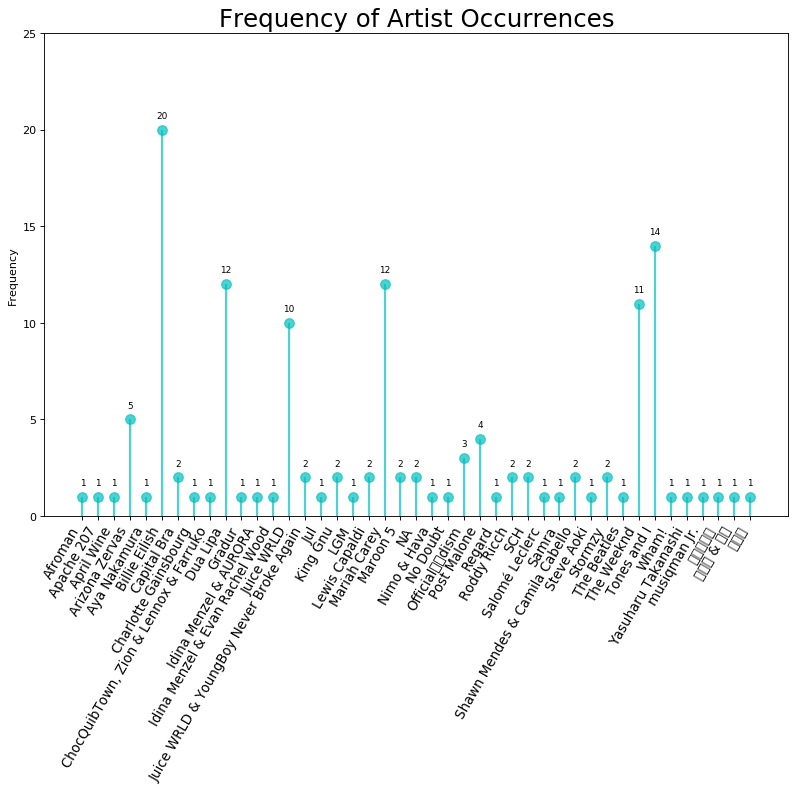

In [43]:
artist = merge_df.groupby(['Artist']).apply(lambda x: x.count())

# Draw plot
fig, ax = plt.subplots(figsize=(12,8), dpi= 80)
ax.vlines(x=artist.index, ymin=0, ymax=artist.Artist, color='c', alpha=0.7, linewidth=2)
ax.scatter(x=artist.index, y=artist.Artist, s=75, color='c', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Frequency of Artist Occurrences', fontdict={'size':22})
ax.set_ylabel('Frequency')
ax.set_xticks(artist.index)
ax.set_xticklabels(artist.index, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 25)

for row in artist.itertuples():
    ax.text(row.Index, row.Artist+.5, s=round(row.Artist, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=8)

plt.show()

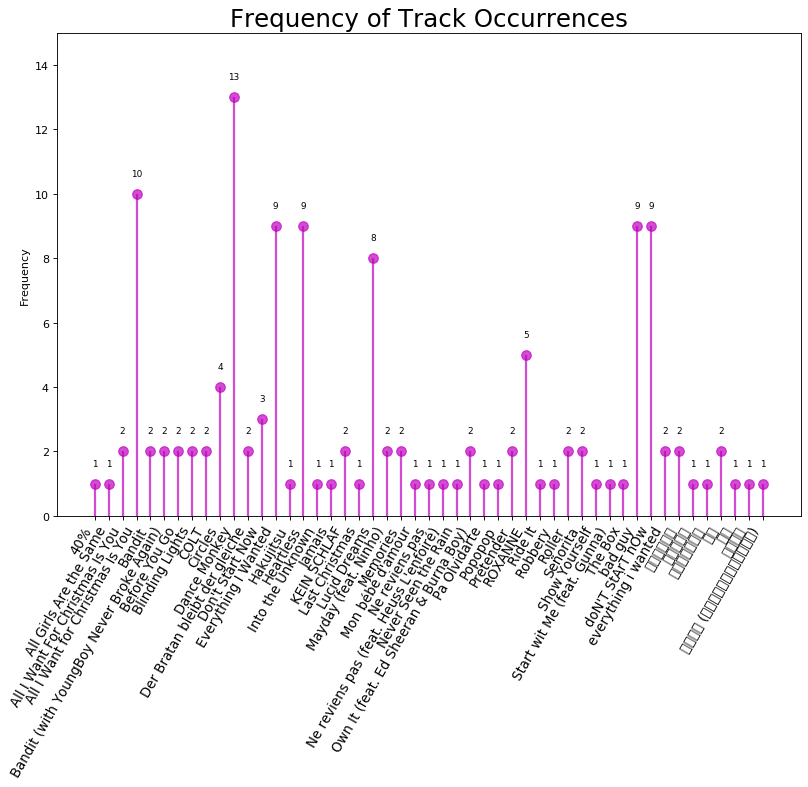

In [52]:
songs = merge_df.groupby(['Name']).apply(lambda x: x.count())

# Draw plot
fig, ax = plt.subplots(figsize=(12,8), dpi= 80)
ax.vlines(x=songs.index, ymin=0, ymax=songs.Name, color='m', alpha=0.7, linewidth=2)
ax.scatter(x=songs.index, y=songs.Name, s=75, color='m', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Frequency of Track Occurrences', fontdict={'size':22})
ax.set_ylabel('Frequency')
ax.set_xticks(songs.index)
ax.set_xticklabels(songs.index, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 15)

for row in songs.itertuples():
    ax.text(row.Index, row.Name+.5, s=round(row.Name, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=8)

plt.show()

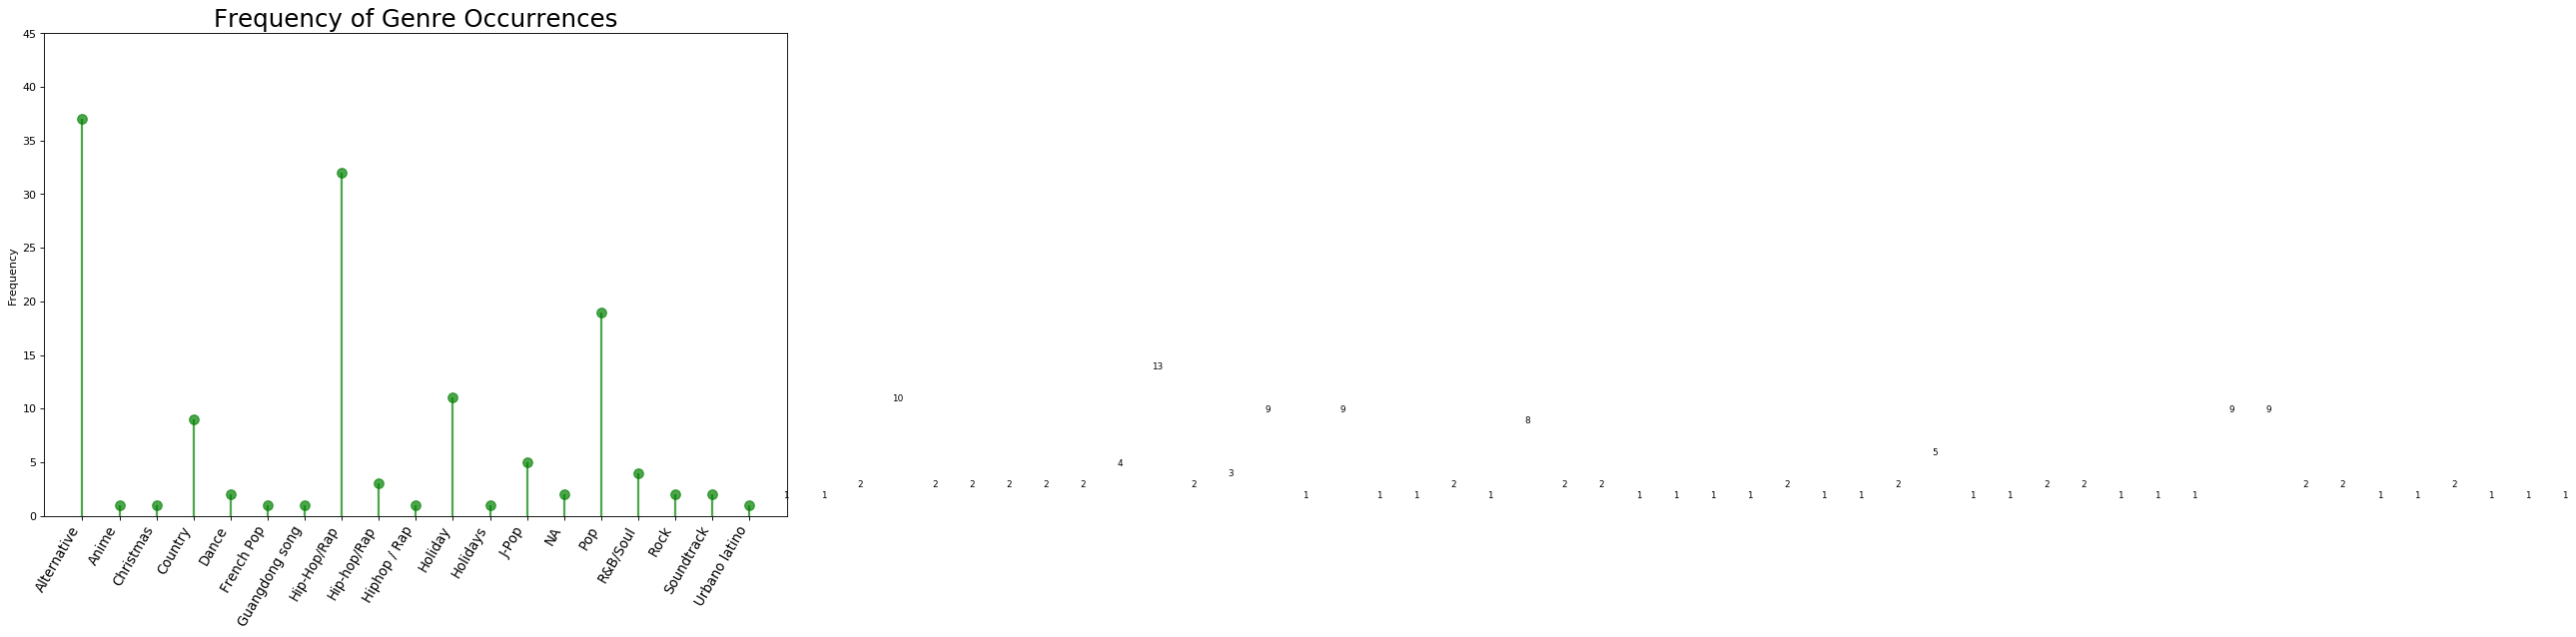

In [56]:
genre = merge_df.groupby(['Genre']).apply(lambda x: x.count())

# Draw plot
fig, ax = plt.subplots(figsize=(12,8), dpi= 80)
ax.vlines(x=genre.index, ymin=0, ymax=genre.Genre, color='g', alpha=0.7, linewidth=2)
ax.scatter(x=genre.index, y=genre.Genre, s=75, color='g', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Frequency of Genre Occurrences', fontdict={'size':22})
ax.set_ylabel('Frequency')
ax.set_xticks(genre.index)
ax.set_xticklabels(genre.index, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 45)

for row in songs.itertuples():
    ax.text(row.Index, row.Genre+.5, s=round(row.Genre, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=8)

plt.show()